In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from tqdm import tqdm

<img src="TwoPatchToy.drawio.png" width="600">

In [45]:
# Establish p-matrix
p_matrix = np.array([
    [14/24, 1/24, 1/24, 8/24],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [8/24, 1/24, 1/24, 14/24]
])
sparse_p = csr_matrix(p_matrix)
p_matrix

array([[0.58333333, 0.04166667, 0.04166667, 0.33333333],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.33333333, 0.04166667, 0.04166667, 0.58333333]])

In [5]:
def long(short):
    long = np.zeros(4)
    long[[0,3]] = short
    return long

In [4]:
data_A = np.array([1, 1, 1, 1, 1, 2, 2, 3, 4, 4])
data_B = np.array([2, 2, 2, 2, 2, 2, 3, 3, 4, 4])

data_A,data_B

(array([1, 1, 1, 1, 1, 2, 2, 3, 4, 4]), array([2, 2, 2, 2, 2, 2, 3, 3, 4, 4]))

In [6]:
# Establish populations
N_vector = np.array([
    5000,4000
])

pop_vector = long(N_vector)

I0 = np.array([100,0,0,100])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

(array([5000.,    0.,    0., 4000.]),
 array([4900.,    0.,    0., 3900.]),
 array([100,   0,   0, 100]))

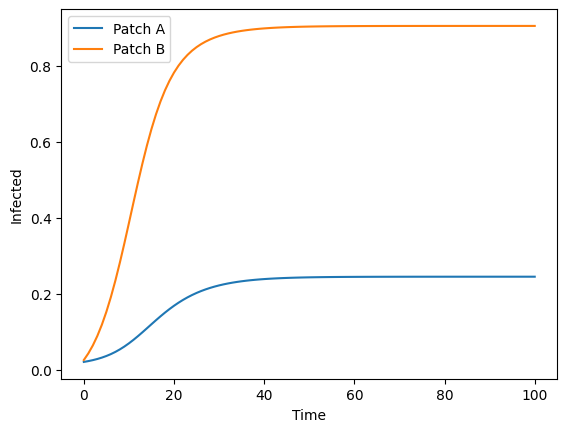

In [7]:
Nj = pop_vector @ p_matrix


def run_model(params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 12))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:4], y[4:8], y[8:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[8:]


beta = np.array([0.1, 0.4, 0.4, 0.8])
gamma = 1/5
gammas = np.ones(4)*gamma
timesteps = 100

output = run_model((S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[3]/pop_vector[3], label='Patch B')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Infected")
plt.show()


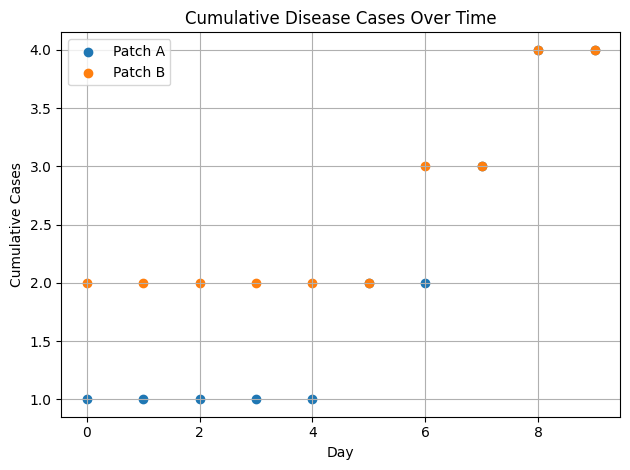

In [50]:
plt.scatter(range(len(data_A)),data_A, label='Patch A')
plt.scatter(range(len(data_B)),data_B, label='Patch B')
plt.xlabel('Day')
plt.ylabel('Cumulative Cases')
plt.title('Cumulative Disease Cases Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Fit betas

timesteps = data_A.shape[0]-1

def run_model_for_fitting(params, p_matrix, pop_vector, timesteps):
    S0, I0, I_total0, beta, gamma = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 12))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:4], y[4:8], y[8:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[8:]  # Return only cumulative infected


# Global best tracking
best_beta = None
best_error = float('inf')

def error_function(beta_guess, data_A, data_B, S0, I0, I_total_0, gamma, timesteps, p_matrix, pop_vector):
    global best_beta, best_error

    beta = beta_guess
    output = run_model_for_fitting((S0, I0, I_total_0, beta, gamma), p_matrix, pop_vector, timesteps)

    pred_A = output[0]
    pred_B = output[3]

    # Normalize
    pred_A /= pop_vector[0]
    pred_B /= pop_vector[3]
    data_A_norm = data_A / pop_vector[0]
    data_B_norm = data_B / pop_vector[3]

    error_matrix = (pred_A - data_A_norm) ** 2 + (pred_B - data_B_norm) ** 2
    squared_error = np.sum(error_matrix)

    # Elastic net
    l1_penalty = 1e-4 * (1 + np.std(beta))
    l2_penalty = 1e-4 * (1 + np.mean(beta)**2)
    total_error = squared_error + l1_penalty + l2_penalty

    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        # print(f"New best beta found. Error: {best_error:.12f}")

    return total_error


def fit_4patch_model(data_A, data_B, S0, I0, I_total_0, gamma, timesteps, p_matrix, pop_vector):
    initial_guess = [0.3, 0.3, 0.3, 0.3]
    bounds = [(0.05, 1.0)] * 4

    res = minimize(
        error_function,
        initial_guess,
        args=(data_A, data_B, S0, I0, I_total_0, gamma, timesteps, p_matrix, pop_vector),
        method='Powell',
        bounds=bounds
    )

    print("Fitted beta:", res.x)
    print("Final error:", res.fun)
    return res.x

fitted_beta = fit_4patch_model(
    data_A=data_A,               # array of shape (T,)
    data_B=data_B,               # array of shape (T,)
    S0=S0,                       # shape (4,)
    I0=I0,                       # shape (4,)
    I_total_0=I_total_0,         # shape (4,)
    gamma=1/10,                   # or whatever recovery rate you're using
    timesteps=timesteps,        # data_A.shape[0] - 1
    p_matrix=p_matrix,          # shape (4, 4), sparse or dense
    pop_vector=pop_vector       # shape (4,)
)

Fitted beta: [0.05       0.05154435 0.05043647 0.0500341 ]
Final error: 0.02147701042624759


In [52]:
fitted_beta = np.array([0.1,0.4,0.4,0.8])

In [39]:
def making_NGM(p_matrix,N_array,betas,gammas):
    size = betas.shape[0]  # 63001 for full London system
    NGM = np.zeros([size,size])
    for i in range(size):
        for j in range(size):
            N_div_a = N_array[i]/gammas[j]
            k_sum = 0
            for k in range(size):
                l_sum = 0
                for l in range(size):
                    l_sum += N_array[l]*p_matrix[l][k]
                
                k_sum += betas[k]*p_matrix[i][k]*p_matrix[j][k]/l_sum
            NGM[i][j] = k_sum*N_div_a
    return NGM

NGM = making_NGM(p_matrix,pop_vector,fitted_beta,gammas)
NGM

array([[2.28152889, 2.85714286, 2.85714286, 3.25451111],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.30180444, 1.14285714, 1.14285714, 2.07882223]])

In [40]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# Ensure NGM is stored efficiently in CSR format
NGM_sparse = csr_matrix(NGM)

# Compute only the largest 251 eigenvalues using shift-invert mode
eigenvalues, eigenvectors = eigs(NGM_sparse, k=1, which="LM", tol=1e-6)

print("Computed Top Eigenvalue:", eigenvalues)


Computed Top Eigenvalue: [4.24100294+0.j]


In [38]:
def modify_p(p_matrix,prop_away):
    new_p_matrix = p_matrix.copy()
    current_3_some_A = new_p_matrix[0][1]+new_p_matrix[0][2]+new_p_matrix[0][3]
    new_p_matrix[0][1:4] *= prop_away/current_3_some_A
    current_3_some_B = new_p_matrix[3][0]+new_p_matrix[3][1]+new_p_matrix[3][2]
    new_p_matrix[3][0:3] *= prop_away/current_3_some_B
    
    new_p_matrix[0][0] = 1-(new_p_matrix[0][1]+new_p_matrix[0][2]+new_p_matrix[0][3])
    new_p_matrix[3][3] = 1-(new_p_matrix[3][0]+new_p_matrix[3][1]+new_p_matrix[3][2])
    return new_p_matrix

def avoid_patch(p_matrix,reduction_percentage):
    # Avoiding patch B
    new_p_matrix = p_matrix.copy()
    
    amount_moved_A = reduction_percentage*new_p_matrix[0][3]
    new_p_matrix[0][0:3] += amount_moved_A*new_p_matrix[0][0:3]/np.sum(new_p_matrix[0][0:3])
    amount_moved_B = reduction_percentage*new_p_matrix[3][3]
    new_p_matrix[3][0:3] += amount_moved_B*new_p_matrix[3][0:3]/np.sum(new_p_matrix[3][0:3])

    new_p_matrix[0][3] *= 1-reduction_percentage
    new_p_matrix[3][3] *= 1-reduction_percentage
    
    return new_p_matrix

In [39]:
np.round(p_matrix,3)

array([[0.666, 0.   , 0.   , 0.333],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.333, 0.   , 0.   , 0.666]])

In [40]:
np.round(modify_p(p_matrix,0.1),3)

array([[0.9, 0. , 0. , 0.1],
       [0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0.1, 0. , 0. , 0.9]])

In [67]:
p_matrix,"\n",avoid_patch(p_matrix,0.1),"\n",np.sum(avoid_patch(p_matrix,0.1),axis=1)

(array([[0.58333333, 0.04166667, 0.04166667, 0.33333333],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        ],
        [0.33333333, 0.04166667, 0.04166667, 0.58333333]]),
 '\n',
 array([[0.6125 , 0.04375, 0.04375, 0.3    ],
        [0.     , 1.     , 0.     , 0.     ],
        [0.     , 0.     , 1.     , 0.     ],
        [0.38   , 0.0475 , 0.0475 , 0.525  ]]),
 '\n',
 array([1., 1., 1., 1.]))

In [28]:
p_matrix

array([[0.41666667, 0.04166667, 0.04166667, 0.33333333],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.33333333, 0.04166667, 0.04166667, 0.41666667]])

In [29]:
modify_p(p_matrix,0.3)

array([[0.7       , 0.03      , 0.03      , 0.24      ],
       [0.        , 0.3       , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.33333333, 0.04166667, 0.04166667, 0.24      ]])

In [26]:
# Make a single function to do all of the above
# Fit betas
def make_R(time_away,p_matrix0):
    
    p_matrix = modify_p(p_matrix0,time_away)
    
    timesteps = data_A.shape[0]-1

    
    NGM = making_NGM(p_matrix,pop_vector,fitted_beta,gammas)
    
    # Ensure NGM is stored efficiently in CSR format
    NGM_sparse = csr_matrix(NGM)

    # Compute only the largest 251 eigenvalues using shift-invert mode
    eigenvalues, eigenvectors = eigs(NGM_sparse, k=1, which="LM", tol=1e-6)
    
    return eigenvalues

make_R(0.01,p_matrix)

array([1.01680096+0.j])

(100,)


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1508271/216243742.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  resulting_R[i] = make_R(time_away_span[i],p_matrix)[0]
100%|██████████| 100/100 [00:00<00:00, 1002.29it/s]


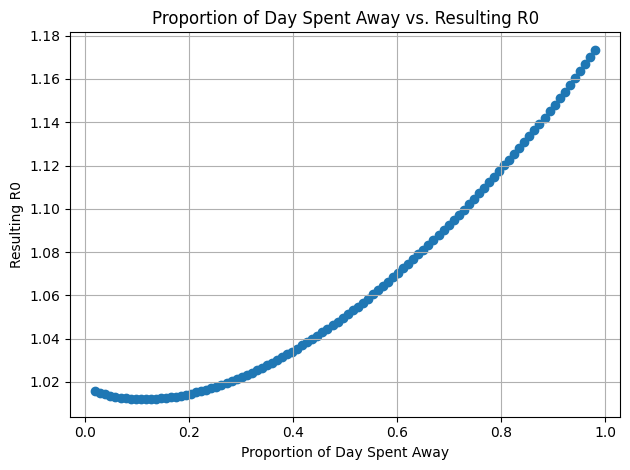

In [27]:
size = 100
time_away_span = np.linspace(0.02,0.98,size)
resulting_R = np.zeros(size)
print(resulting_R.shape)
for i in tqdm(range(size)):
    resulting_R[i] = make_R(time_away_span[i],p_matrix)[0]
    
plt.scatter(time_away_span,resulting_R)
plt.xlabel('Proportion of Day Spent Away')
plt.ylabel('Resulting R0')
plt.title('Proportion of Day Spent Away vs. Resulting R0')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def make_plots(params, p_matrix0, proportions):
    output = []
    for prop in proportions:
        p_matrix = modify_p(p_matrix0,prop)
        
        Nj = pop_vector @ p_matrix


        def run_model(params):
            S0, I0, I_total0, beta, gamma, timesteps = params
            y0 = np.concatenate((S0, I0, I_total0))
            beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
            t = np.linspace(0, timesteps, num=timesteps)
            y_log = np.zeros((len(t)+1, 12))
            y_log[0] = y0

            def sir(y):
                S, I, I_total = y[:4], y[4:8], y[8:]
                Ij = p_matrix.T @ I
                Ij_div_Nj = Ij / Nj
                inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
                dSdt = -inf
                dIdt = inf - gamma * I
                dI_totaldt = -dSdt
                return np.concatenate((dSdt, dIdt, dI_totaldt))

            for step in range(len(t)):
                y_log[step+1] = y_log[step] + sir(y_log[step])

            return y_log.T[4:8]


        beta = fitted_beta
        gamma = 1/10
        gammas = np.ones(4)*gamma
        timesteps = 300

        output0 = run_model((S0, I0, I_total_0, beta, gamma, timesteps))
        output.append(output0)
    return output

beta = fitted_beta
gamma = 1/5
gammas = np.ones(4)*gamma
timesteps = 300
props = np.array([0.1,0.4,0.7])
solution = np.array(make_plots((S0, I0, I_total_0, beta, gamma, timesteps),p_matrix,props))

t = np.linspace(0, timesteps, timesteps+1)

plt.figure(figsize=(10,6))
plt.plot(t, solution[0][0]/pop_vector[0], label=f'Patch A {props[0]:.2f}', color="blue", linestyle="-")
plt.plot(t, solution[1][0]/pop_vector[0], label=f'Patch A {props[1]:.2f}', color="blue", linestyle="--")
plt.plot(t, solution[2][0]/pop_vector[0], label=f'Patch A {props[2]:.2f}', color="blue", linestyle=":")
plt.plot(t, solution[0][3]/pop_vector[3], label=f'Patch B {props[0]:.2f}', color="orange", linestyle="-")
plt.plot(t, solution[1][3]/pop_vector[3], label=f'Patch B {props[1]:.2f}', color="orange", linestyle="--")
plt.plot(t, solution[2][3]/pop_vector[3], label=f'Patch B {props[2]:.2f}', color="orange", linestyle=":")
plt.legend(ncol=2,title="Patch, Proportion spent outside Home")
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Infection Proportions")
plt.show()


NameError: name 'fitted_beta' is not defined

In [42]:
fitted_beta = np.array([0.1,0.1,0.1,0.9])

Current p_matrix: (reduction proportion= 0.1 )
 [[0.9  0.01 0.01 0.08]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.08 0.01 0.01 0.9 ]]
Current p_matrix: (reduction proportion= 0.5 )
 [[0.5  0.05 0.05 0.4 ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.4  0.05 0.05 0.5 ]]
Current p_matrix: (reduction proportion= 0.9 )
 [[0.1  0.09 0.09 0.72]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.72 0.09 0.09 0.1 ]]


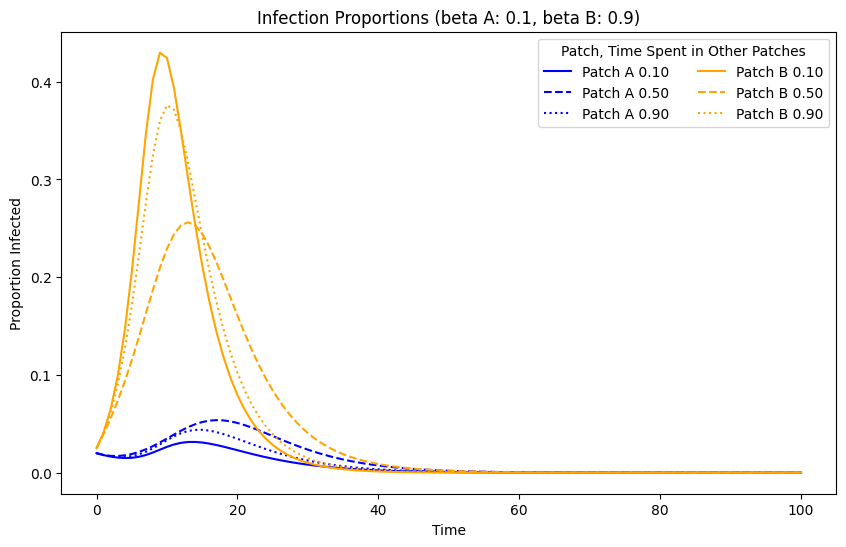

In [49]:
def make_plots(params, p_matrix0, proportions):
    output = []
    for prop in proportions:
        p_matrix = modify_p(p_matrix0,prop)
        print("Current p_matrix: (reduction proportion=",prop,")\n",np.round(p_matrix,3))
        
        Nj = pop_vector @ p_matrix


        def run_model(params):
            S0, I0, I_total0, beta, gamma, timesteps = params
            y0 = np.concatenate((S0, I0, I_total0))
            beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
            t = np.linspace(0, timesteps, num=timesteps)
            y_log = np.zeros((len(t)+1, 12))
            y_log[0] = y0

            def sir(y):
                S, I, I_total = y[:4], y[4:8], y[8:]
                Ij = p_matrix.T @ I
                Ij_div_Nj = Ij / Nj
                inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
                dSdt = -inf
                dIdt = inf - gamma * I
                dI_totaldt = -dSdt
                return np.concatenate((dSdt, dIdt, dI_totaldt))

            for step in range(len(t)):
                y_log[step+1] = y_log[step] + sir(y_log[step])

            return y_log.T[4:8]


        beta = fitted_beta
        gamma = 1/5
        gammas = np.ones(4)*gamma
        timesteps = 100

        output0 = run_model((S0, I0, I_total_0, beta, gamma, timesteps))
        output.append(output0)
    return output

beta = fitted_beta
gamma = 1/5
gammas = np.ones(4)*gamma
timesteps = 100
props = np.array([0.1,0.5,0.9])
solution = np.array(make_plots((S0, I0, I_total_0, beta, gamma, timesteps),p_matrix,props))

t = np.linspace(0, timesteps, timesteps+1)

plt.figure(figsize=(10,6))
plt.plot(t, solution[0][0]/pop_vector[0], label=f'Patch A {props[0]:.2f}', color="blue", linestyle="-")
plt.plot(t, solution[1][0]/pop_vector[0], label=f'Patch A {props[1]:.2f}', color="blue", linestyle="--")
plt.plot(t, solution[2][0]/pop_vector[0], label=f'Patch A {props[2]:.2f}', color="blue", linestyle=":")
plt.plot(t, solution[0][3]/pop_vector[3], label=f'Patch B {props[0]:.2f}', color="orange", linestyle="-")
plt.plot(t, solution[1][3]/pop_vector[3], label=f'Patch B {props[1]:.2f}', color="orange", linestyle="--")
plt.plot(t, solution[2][3]/pop_vector[3], label=f'Patch B {props[2]:.2f}', color="orange", linestyle=":")
plt.legend(ncol=2,title="Patch, Time Spent in Other Patches")
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title(f"Infection Proportions (beta A: 0.1, beta B: 0.9)")
plt.show()


Current p_matrix: (reduction proportion= 0.01 )
 [[0.669 0.    0.    0.33 ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.34  0.    0.    0.659]]
Current p_matrix: (reduction proportion= 0.5 )
 [[0.832 0.001 0.001 0.167]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.665 0.001 0.001 0.333]]
Current p_matrix: (reduction proportion= 0.99 )
 [[0.995 0.001 0.001 0.003]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.991 0.001 0.001 0.007]]


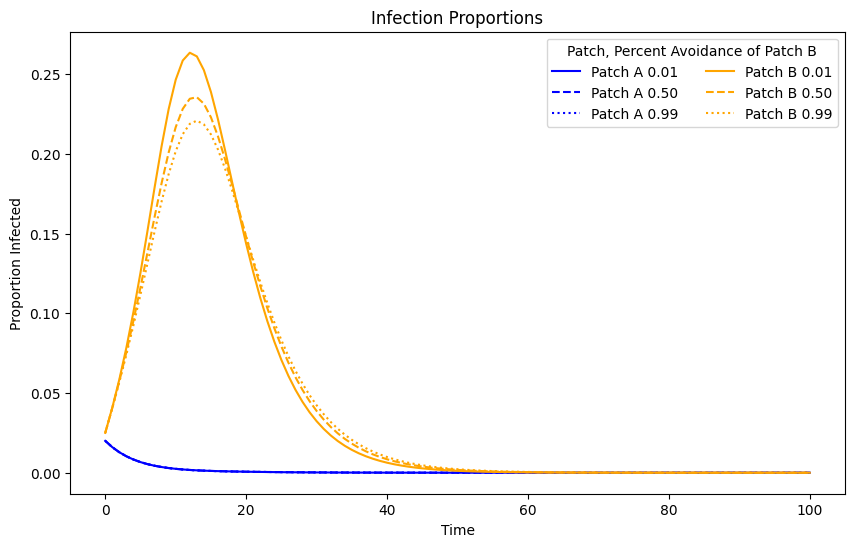

In [22]:
def make_plots(params, p_matrix0, proportions):
    output = []
    for prop in proportions:
        p_matrix = avoid_patch(p_matrix0,prop)
        print("Current p_matrix: (reduction proportion=",prop,")\n",np.round(p_matrix,3))
        
        Nj = pop_vector @ p_matrix


        def run_model(params):
            S0, I0, I_total0, beta, gamma, timesteps = params
            y0 = np.concatenate((S0, I0, I_total0))
            beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
            t = np.linspace(0, timesteps, num=timesteps)
            y_log = np.zeros((len(t)+1, 12))
            y_log[0] = y0

            def sir(y):
                S, I, I_total = y[:4], y[4:8], y[8:]
                Ij = p_matrix.T @ I
                Ij_div_Nj = Ij / Nj
                inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
                dSdt = -inf
                dIdt = inf - gamma * I
                dI_totaldt = -dSdt
                return np.concatenate((dSdt, dIdt, dI_totaldt))

            for step in range(len(t)):
                y_log[step+1] = y_log[step] + sir(y_log[step])

            return y_log.T[4:8]


        beta = fitted_beta
        gamma = 1/5
        gammas = np.ones(4)*gamma
        timesteps = 100

        output0 = run_model((S0, I0, I_total_0, beta, gamma, timesteps))
        output.append(output0)
    return output

beta = fitted_beta
gamma = 1/5
gammas = np.ones(4)*gamma
timesteps = 100
props = np.array([0.01,0.5,0.99])
solution = np.array(make_plots((S0, I0, I_total_0, beta, gamma, timesteps),p_matrix,props))

t = np.linspace(0, timesteps, timesteps+1)

plt.figure(figsize=(10,6))
plt.plot(t, solution[0][0]/pop_vector[0], label=f'Patch A {props[0]:.2f}', color="blue", linestyle="-")
plt.plot(t, solution[1][0]/pop_vector[0], label=f'Patch A {props[1]:.2f}', color="blue", linestyle="--")
plt.plot(t, solution[2][0]/pop_vector[0], label=f'Patch A {props[2]:.2f}', color="blue", linestyle=":")
plt.plot(t, solution[0][3]/pop_vector[3], label=f'Patch B {props[0]:.2f}', color="orange", linestyle="-")
plt.plot(t, solution[1][3]/pop_vector[3], label=f'Patch B {props[1]:.2f}', color="orange", linestyle="--")
plt.plot(t, solution[2][3]/pop_vector[3], label=f'Patch B {props[2]:.2f}', color="orange", linestyle=":")
plt.legend(ncol=2,title="Patch, Percent Avoidance of Patch B")
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Infection Proportions")
plt.show()
